# Differencing

Apziva project #5: ValueInvestor<br>
2023 09 04

__Summary:__
* In this notebook time series data is converted into __daily differences__ of log scale prices.
* There are __no obvious seasonal or linear trends__ over time.

## TOC: <a class="anchor" id="TOC"></a>
* [Utilities](#Utilities)
* [Installation](#Installation)
* [Get data](#GetData)
* [Interpolate](#Interpolate)
* [Differencing](#Differencing)

## Utilities <a class="anchor" id="Utilities"></a>
[TOC](#TOC)

In [1]:
# own libraries
import Utilities as u
import MachineLearning as ml

# activate changes in libraries
import importlib
importlib.reload(u)
importlib.reload(ml)

# aliases
from Utilities import TypeChecker as t
from Utilities import PrintAlias as p

def ShortDataFrameDisplay(dfrSource,cintExamples=5):
    p(f"DataFrame '{u.VariableName(dfrSource)}':")
    pd.options.display.max_rows = cintExamples
    u.DisplayDataFrame(dfrSource)
    pd.reset_option('display.max_rows')

## Installation <a class="anchor" id="Installation"></a>
[TOC](#TOC)

In [2]:
# installation
# pip install gradio

## Get data <a class="anchor" id="GetData"></a>
[TOC](#TOC)

In [3]:
import pickle
import pandas as pd
strFilename = f"../data/processed/dfrLog.p"
with open(strFilename, 'rb') as objBufferedWriter: # rb = read in binary mode
    dfrLog = pickle.load(objBufferedWriter)
ShortDataFrameDisplay(dfrLog)

DataFrame 'dfrLog':


,Weekday,Date,Open,High,Low,Close,Price,LogOpen,LogHigh,LogLow,LogClose,LogPrice
0,Thursday,1986-03-13,0.055004,0.063093,0.055004,0.060396,0.057700,-1.259604,-1.200018,-1.259604,-1.218989,-1.238822
1,Friday,1986-03-14,0.060396,0.063632,0.060396,0.062553,0.061475,-1.218988,-1.196322,-1.218988,-1.203749,-1.211302
...,...,...,...,...,...,...,...,...,...,...,...,...
9445,Tuesday,2023-09-05,329.000000,334.850006,328.660004,333.549988,331.274994,2.517196,2.524850,2.516747,2.523161,2.520189
9446,Wednesday,2023-09-06,333.380005,334.459991,330.179993,332.880005,333.130005,2.522940,2.524344,2.518751,2.522288,2.522614


## Interpolation <a class="anchor" id="Interpolation"></a>
[TOC](#TOC)

In [4]:
dfrInterpolated = dfrLog.copy()[["Date","LogPrice"]]
ShortDataFrameDisplay(dfrInterpolated,7)

DataFrame 'dfrInterpolated':


,Date,LogPrice
0,1986-03-13,-1.238822
1,1986-03-14,-1.211302
2,1986-03-17,-1.200020
...,...,...
9444,2023-09-01,2.518494
9445,2023-09-05,2.520189
9446,2023-09-06,2.522614


In [5]:
import pandas as pd

def InterpolateDataFrame(dfrSource,strDateColumn,strValueColumn):
    
    # init
    dfrSource[strDateColumn] = pd.to_datetime(dfrSource[strDateColumn])
    dfrSource.set_index(strDateColumn, inplace=True)

    # get date range and re-index
    objDateRange = pd.date_range(start=dfrSource.index.min(), end=dfrSource.index.max())
    dfrSource = dfrSource.reindex(objDateRange).rename_axis(strDateColumn).reset_index()

    # interpolate the missing values linearly
    dfrSource[strValueColumn] = dfrSource[strValueColumn].interpolate(method='linear')
    
    # finalize
    return dfrSource

if False:
    dfltSampleData = {
        'Date': ['2023-09-01', '2023-09-03', '2023-09-06'],
        'MyValues': [1.0, 2.0, 4.0]}
    dfrSampleData = pd.DataFrame(dfltSampleData) 
    u.DisplayDataFrame(dfrSampleData)
    dfrResult = InterpolateDataFrame(dfrSampleData,"Date","MyValues") 
    u.DisplayDataFrame(dfrResult)

dfrInterpolated = InterpolateDataFrame(dfrInterpolated,"Date","LogPrice") 
dfrInterpolated

,Date,LogPrice
0,1986-03-13,-1.238822
1,1986-03-14,-1.211302
2,1986-03-15,-1.207541
3,1986-03-16,-1.203781
4,1986-03-17,-1.200020
...,...,...
13687,2023-09-02,2.518918
13688,2023-09-03,2.519341
13689,2023-09-04,2.519765
13690,2023-09-05,2.520189


In [6]:
def CheckNewYear(dfrSource):
    '''
    Checks a dateframe for the days between 2022 and 2023
    When       Who What
    2023 09 08 dh  Created
    '''
    p("Check new year 2022/2023:")
    strStartDate = '2022-12-24'
    strEndDate   = '2023-01-06'
    dfrFiltered = dfrSource[(dfrSource['Date'] >= strStartDate) \
                                  & (dfrSource['Date'] <= strEndDate)]
    u.DisplayDataFrame(dfrFiltered)
    
CheckNewYear(dfrInterpolated)    

Check new year 2022/2023:


,Date,LogPrice
13435,2022-12-24,2.372751
13436,2022-12-25,2.372939
13437,2022-12-26,2.373126
13438,2022-12-27,2.373313
13439,2022-12-28,2.369425
13440,2022-12-29,2.374225
13441,2022-12-30,2.375472
13442,2022-12-31,2.376518
13443,2023-01-01,2.377565
13444,2023-01-02,2.378611


## Differencing <a class="anchor" id="Differencing"></a>
[TOC](#TOC)

In [7]:
# differencing
dfrDifferencing = dfrInterpolated.copy()
dfrDifferencing['DiffLogPrice'] = dfrDifferencing['LogPrice'].diff().fillna(0)
u.ToDisk(dfrDifferencing,strForcedName="dfrDifferencing",strType="processed")
dfrDifferencing

,Date,LogPrice,DiffLogPrice
0,1986-03-13,-1.238822,0.000000
1,1986-03-14,-1.211302,0.027520
2,1986-03-15,-1.207541,0.003761
3,1986-03-16,-1.203781,0.003761
4,1986-03-17,-1.200020,0.003761
...,...,...,...
13687,2023-09-02,2.518918,0.000424
13688,2023-09-03,2.519341,0.000424
13689,2023-09-04,2.519765,0.000424
13690,2023-09-05,2.520189,0.000424


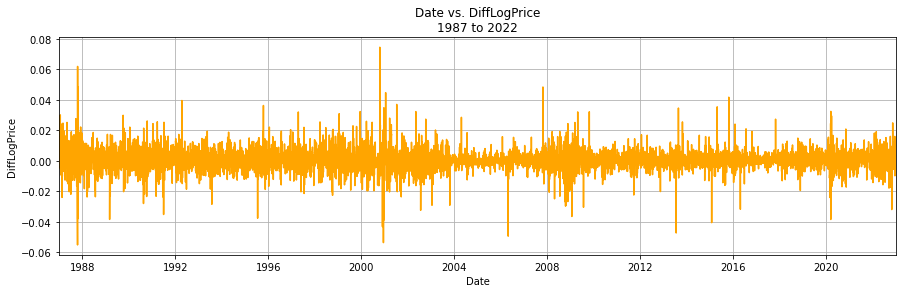

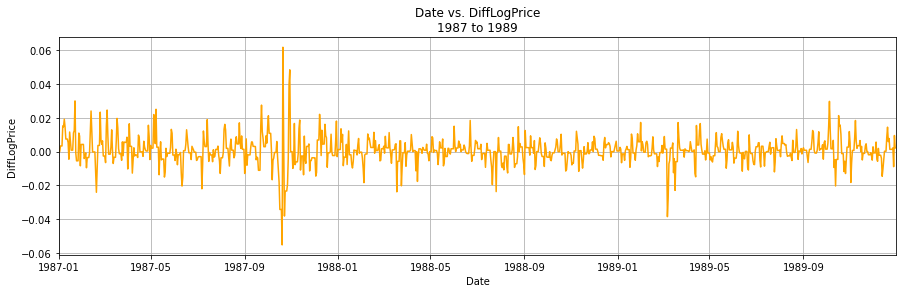

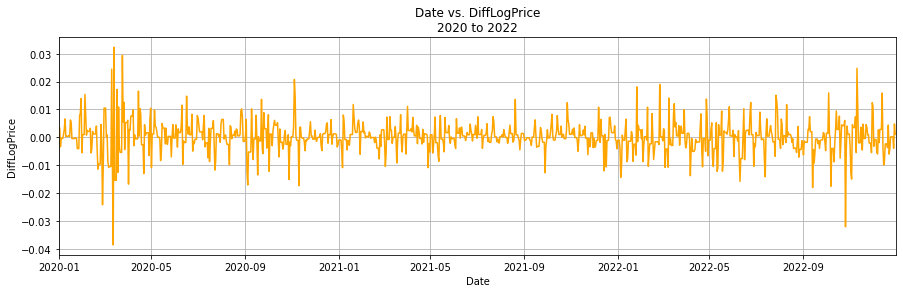

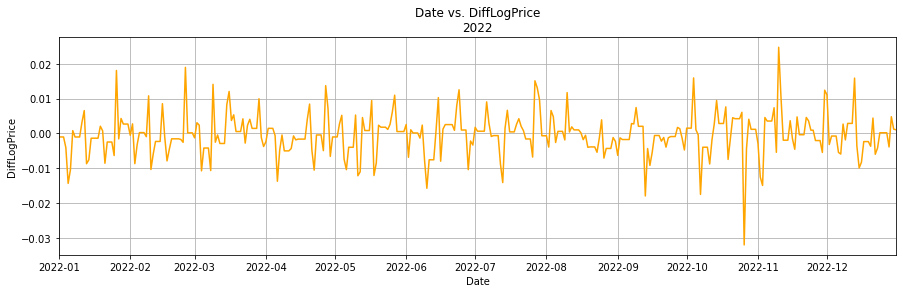

In [25]:
import matplotlib.pyplot as plt

def PlotDifferences(dfrSource,intStartYear,intEndYear):

    objStartDate = pd.to_datetime(f'{intStartYear}-01-01')
    objEndDate   = pd.to_datetime(f'{intEndYear}-12-31')
    
    dfrYearsRequested = dfrDifferencing[
            (dfrDifferencing['Date'] >= objStartDate)
            &
            (dfrDifferencing['Date'] <= objEndDate)
    ]

    # Create the plot
    plt.figure(figsize=(15, 4))
    plt.plot(dfrYearsRequested['Date'], dfrYearsRequested['DiffLogPrice'], color='orange')

    # Customize the plot
    strYearSpan = f"{intStartYear}" if intStartYear == intEndYear else f"{intStartYear} to {intEndYear}"
    plt.xlabel('Date')
    plt.ylabel('DiffLogPrice')
    plt.title(f'Date vs. DiffLogPrice\n{strYearSpan}')
    plt.xlim(objStartDate, objEndDate)
    plt.grid(True)

    # Show the plot
    plt.show()
    
PlotDifferences(dfrDifferencing,1987,2022)
PlotDifferences(dfrDifferencing,1987,1989)
PlotDifferences(dfrDifferencing,2020,2022)
PlotDifferences(dfrDifferencing,2022,2022)

__Observations__
* No (obvious) seasonality.
* No (obvious) upward trend.
* Periods of extended volatility:
    * October 1987.
    * March 2020 (Covid).
    * November 2022.